<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.1 MB/s 
     |████████████████████████████████| 71 kB 7.4 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619352 sha256=96ce0113a59ca48e965765daaaa97606fa0afb3383a926fbb79e3d9469912a66
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=4a7d7d1194e29b3a4e37d00301b4e2b1a61b4d64c5b13c227586eee6bc433b32
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73656 sha

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.2,0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [00:52,  3.68 files/s]


In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max',
                    classes=5)

output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        zoom_range=0.2,
                                                        shear_range=0.2,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')# with data augmentation for train set
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [ ]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.1413 - accuracy: 0.2162

LOSS:	2.141310930252075 	 ACCURACY:	0.21621622145175934
[2.141310930252075, 0.21621622145175934]



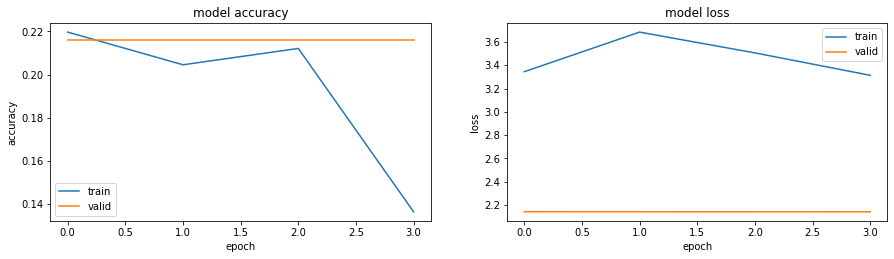


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 1.0e+00 5.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 1.9682 - accuracy: 0.1892

LOSS:	1.968196153640747 	 ACCURACY:	0.18918919563293457
[1.968196153640747, 0.18918919563293457]



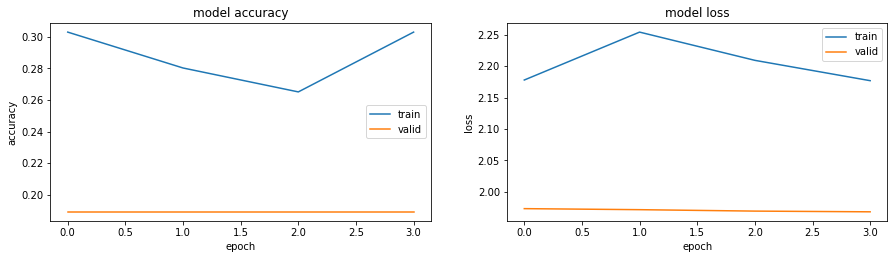


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 7.3433 - accuracy: 0.1351

LOSS:	7.343296527862549 	 ACCURACY:	0.13513512909412384
[7.343296527862549, 0.13513512909412384]



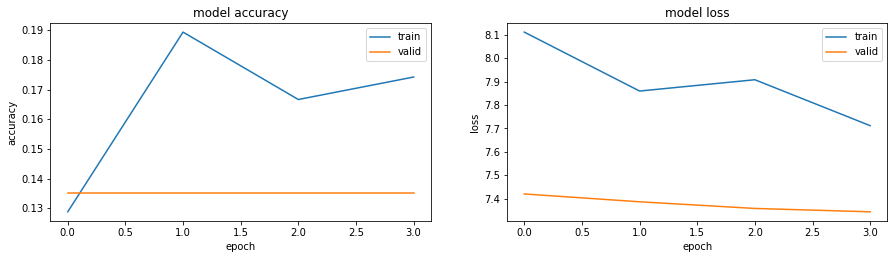


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.02703, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.02703

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.02703

Epoch 4: val_accuracy did not improve from 0.02703
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 104.8309 - accuracy: 0.0000e+00

LOSS:	104.83091735839844 	 ACCURACY:	0.0
[104.83091735839844, 0.0]



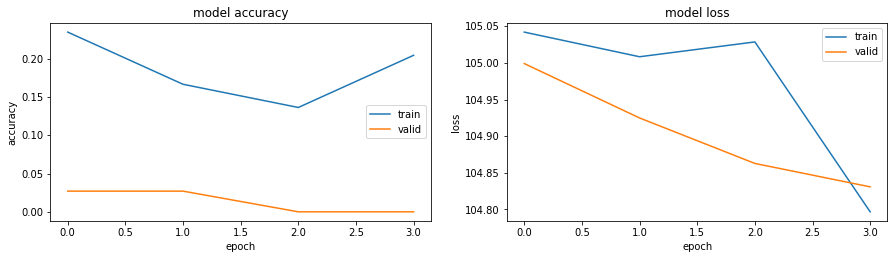


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.2695 - accuracy: 0.1351

LOSS:	2.269544839859009 	 ACCURACY:	0.13513512909412384
[2.269544839859009, 0.13513512909412384]



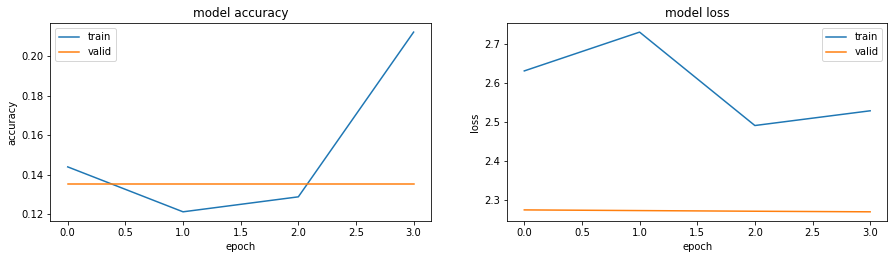




Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 3.5654 - accuracy: 0.1622

LOSS:	3.565443277359009 	 ACCURACY:	0.1621621549129486
[3.565443277359009, 0.1621621549129486]



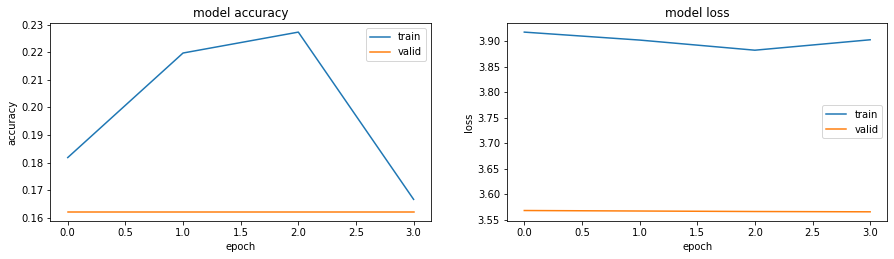


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 16.0584 - accuracy: 0.1622

LOSS:	16.058425903320312 	 ACCURACY:	0.1621621549129486
[16.058425903320312, 0.1621621549129486]



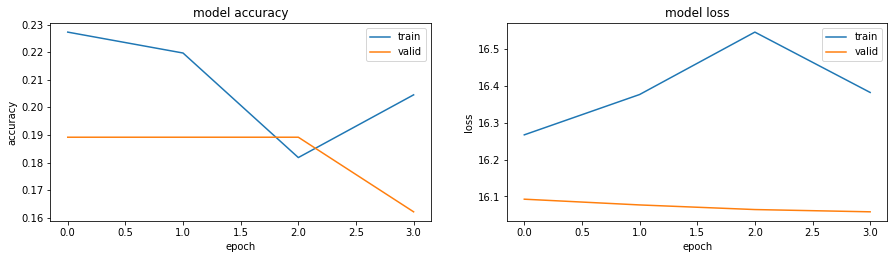


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.9352 - accuracy: 0.0811

LOSS:	4.935197830200195 	 ACCURACY:	0.0810810774564743
[4.935197830200195, 0.0810810774564743]



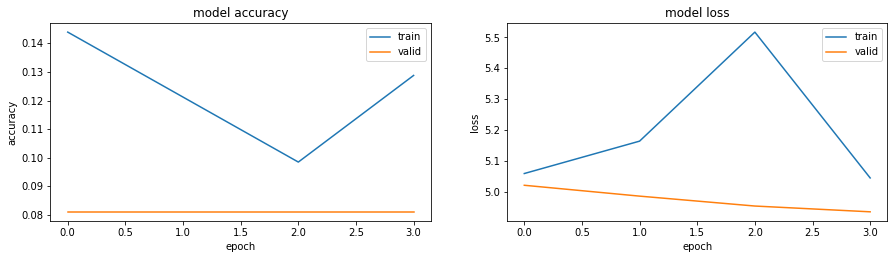


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 3.1326 - accuracy: 0.0811

LOSS:	3.1325976848602295 	 ACCURACY:	0.0810810774564743
[3.1325976848602295, 0.0810810774564743]



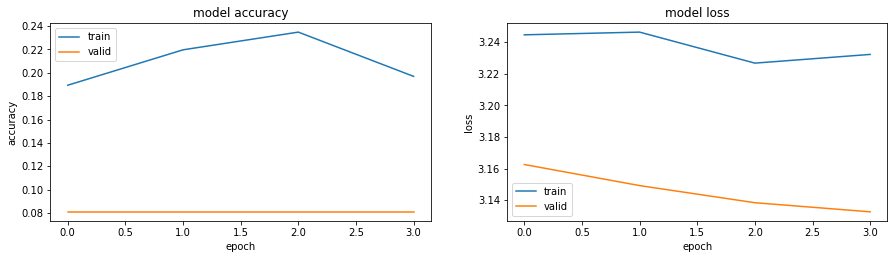


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.1413 - accuracy: 0.2162

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.6735 - accuracy: 0.4054

LOSS:	1.6734800338745117 	 ACCURACY:	0.4054054021835327
[1.6734800338745117, 0.4054054021835327]



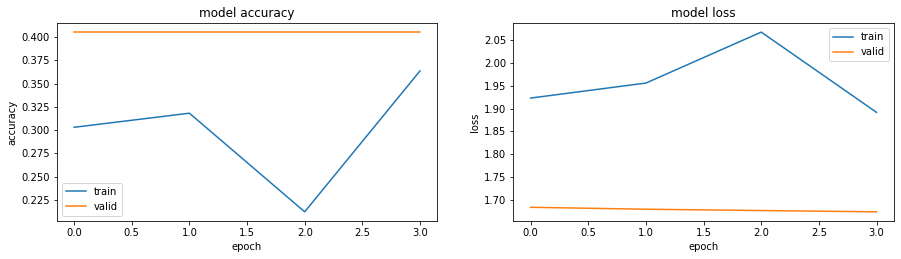


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 1.6735 - accuracy: 0.4054

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: val_accuracy did not improve from 0.45946
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.5971 - accuracy: 0.4595

LOSS:	1.5971277952194214 	 ACCURACY:	0.45945945382118225
[1.5971277952194214, 0.45945945382118225]



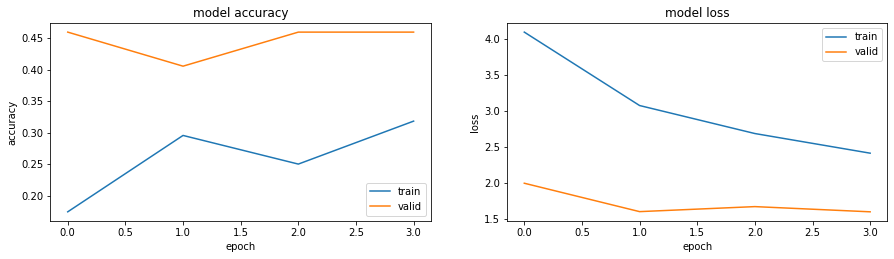


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 1.5971 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 11.9433 - accuracy: 0.4054

LOSS:	11.943347930908203 	 ACCURACY:	0.4054054021835327
[11.943347930908203, 0.4054054021835327]



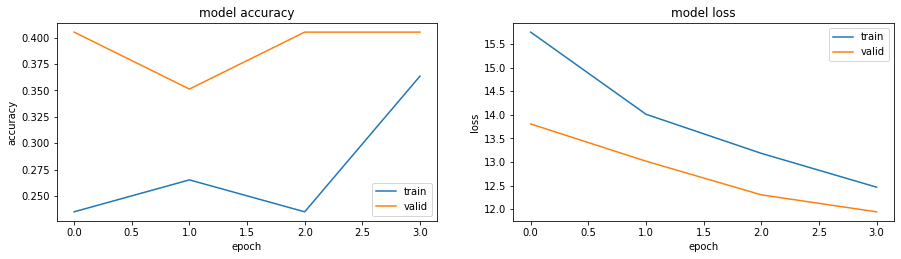


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 2.0e+00 3.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 1.5971 - accuracy: 0.4595

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.51351, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.51351

Epoch 7: val_accuracy did not improve from 0.51351
Epoch 7: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

LOSS:	2.3861262798309326 	 ACCURACY:	0.5135135054588318
[2.3861262798309326, 0.5135135054588318]



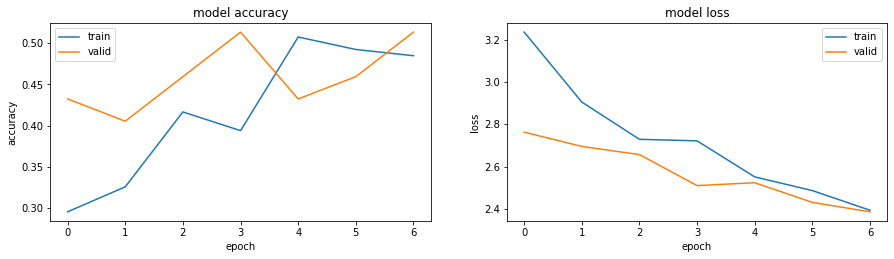


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-01 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 16.3451 - accuracy: 0.1351

LOSS:	16.345125198364258 	 ACCURACY:	0.13513512909412384
[16.345125198364258, 0.13513512909412384]



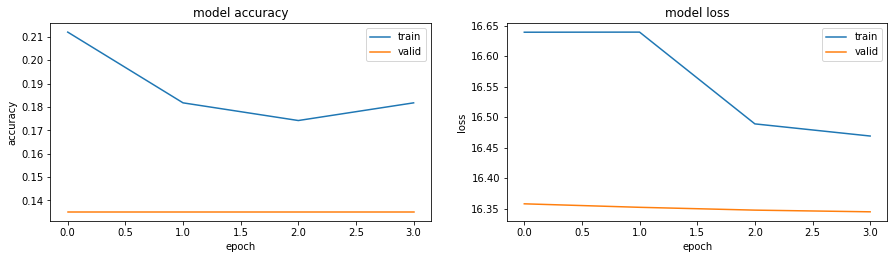


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.48649 to 0.54054, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.54054

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: val_accuracy did not improve from 0.54054
Epoch 9: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.5149 - accuracy: 0.4865

LOSS:	1.5149391889572144 	 ACCURACY:	0.486486494541168

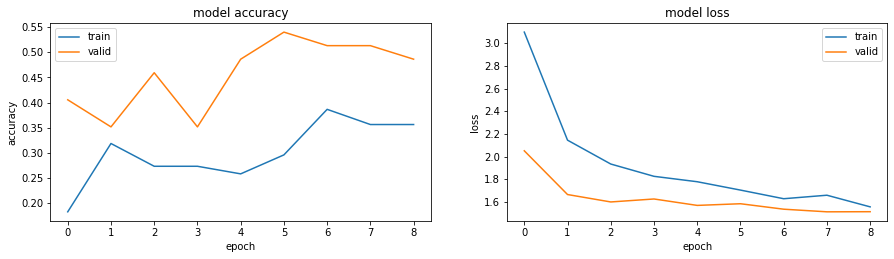


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 2.3776 - accuracy: 0.1622

LOSS:	2.377579927444458 	 ACCURACY:	0.1621621549129486
[2.377579927444458, 0.1621621549129486]



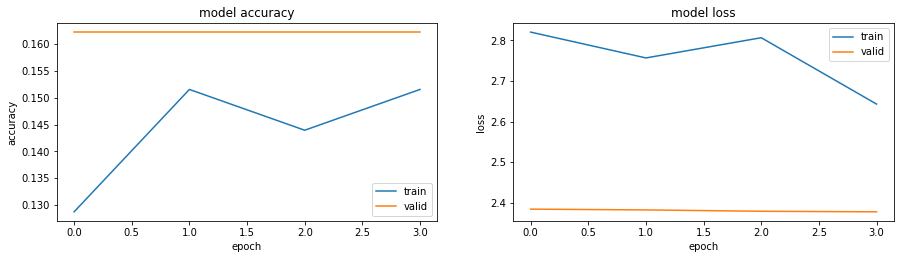


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 3.8072 - accuracy: 0.1081

LOSS:	3.8071646690368652 	 ACCURACY:	0.10810811072587967
[3.8071646690368652, 0.10810811072587967]



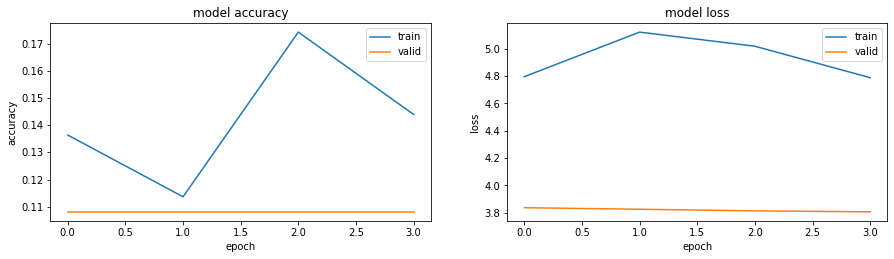


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 12.0724 - accuracy: 0.3514

LOSS:	12.072367668151855 	 ACCURACY:	0.3513513505458832
[12.072367668151855, 0.3513513505458832]



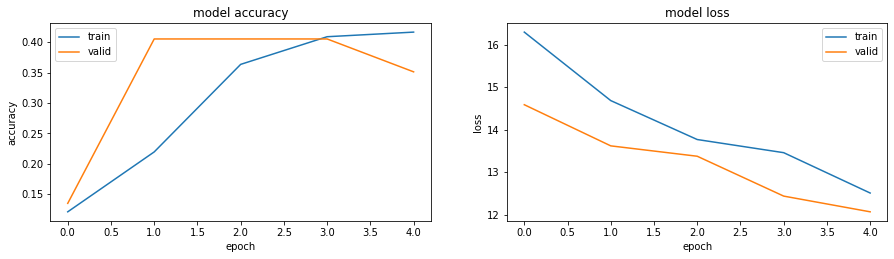


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.3131 - accuracy: 0.0811

LOSS:	2.3130762577056885 	 ACCURACY:	0.0810810774564743
[2.3130762577056885, 0.0810810774564743]



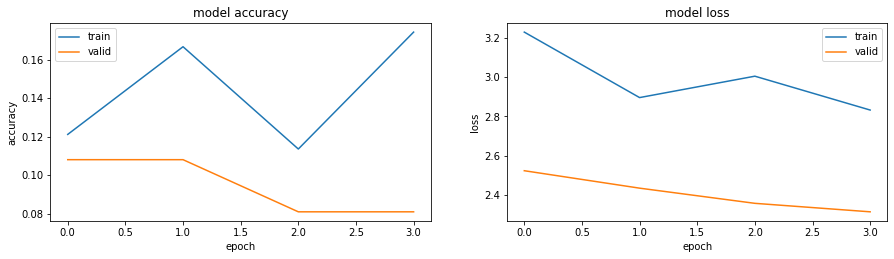


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-01 3.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 16.1066 - accuracy: 0.1351

LOSS:	16.106597900390625 	 ACCURACY:	0.13513512909412384
[16.106597900390625, 0.13513512909412384]



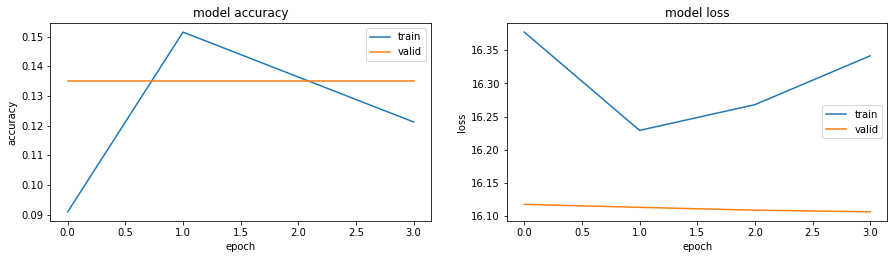


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 2.0e+00 5.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 3.1107 - accuracy: 0.1622

LOSS:	3.110690116882324 	 ACCURACY:	0.1621621549129486
[3.110690116882324, 0.1621621549129486]



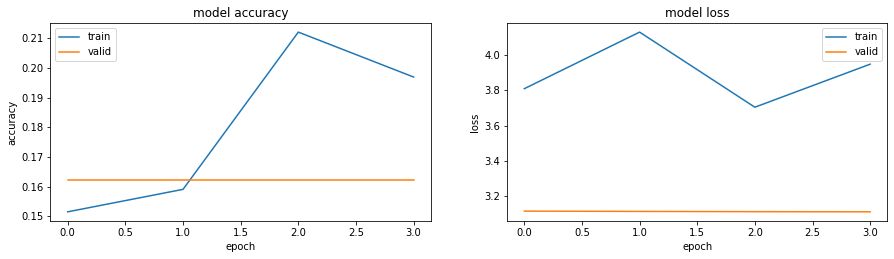


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 15.3588 - accuracy: 0.2432

LOSS:	15.35876750946045 	 ACCURACY:	0.2432432472705841
[15.35876750946045, 0.2432432472705841]



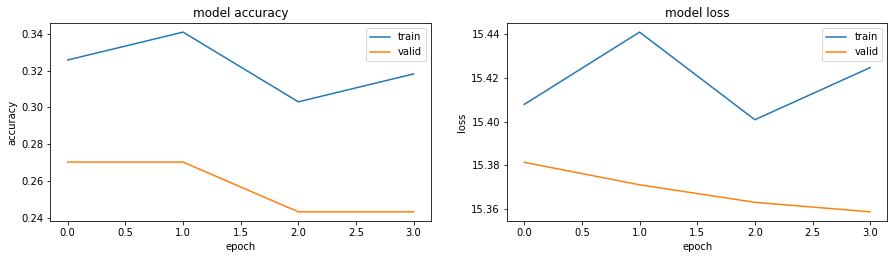


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 2.9052 - accuracy: 0.1351

LOSS:	2.9051644802093506 	 ACCURACY:	0.13513512909412384
[2.9051644802093506, 0.13513512909412384]



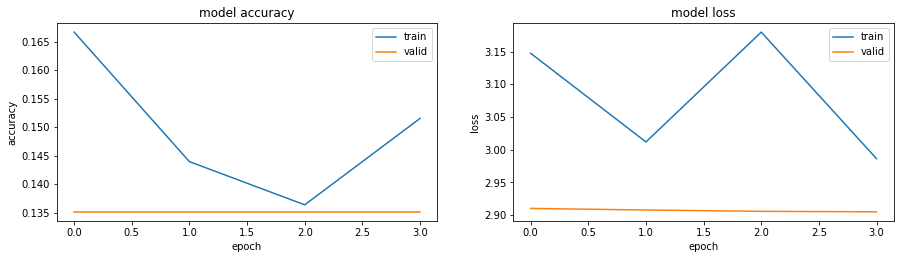


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 1.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy did not improve from 0.45946
Epoch 7: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 1.5580 - accuracy: 0.4324

LOSS:	1.5580337047576904 	 ACCURACY:	0.4324324429035187
[1.5580337047576904, 0.4324324429035187]



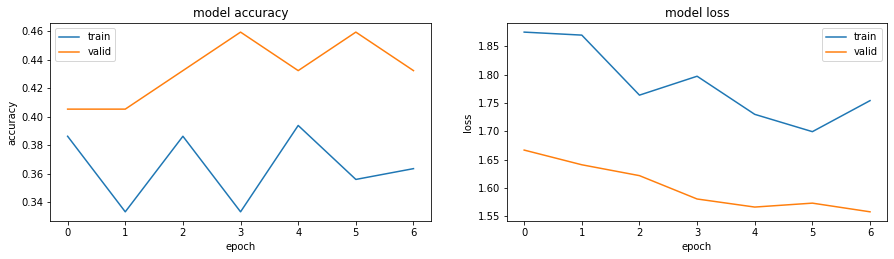


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 2.0e+00 5.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 3.2799 - accuracy: 0.0811

LOSS:	3.27990460395813 	 ACCURACY:	0.0810810774564743
[3.27990460395813, 0.0810810774564743]



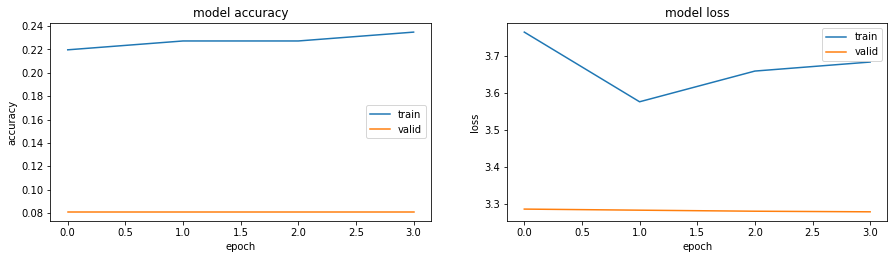


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.5171 - accuracy: 0.1351

LOSS:	2.5170726776123047 	 ACCURACY:	0.13513512909412384
[2.5170726776123047, 0.13513512909412384]



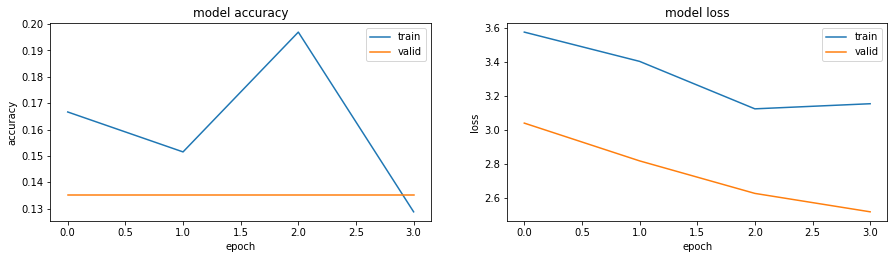


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.9370 - accuracy: 0.2432

LOSS:	15.937005043029785 	 ACCURACY:	0.2432432472705841
[15.937005043029785, 0.2432432472705841]



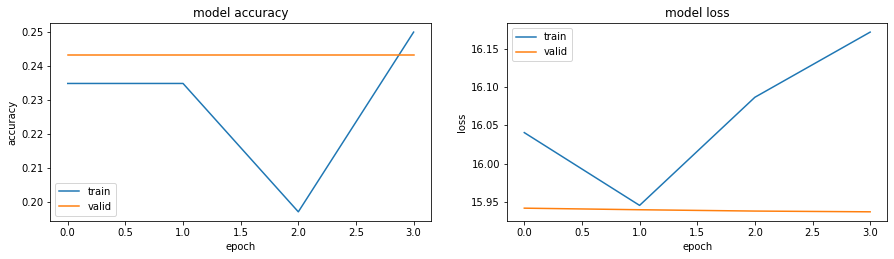


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 16.1725 - accuracy: 0.1351

LOSS:	16.172466278076172 	 ACCURACY:	0.13513512909412384
[16.172466278076172, 0.13513512909412384]



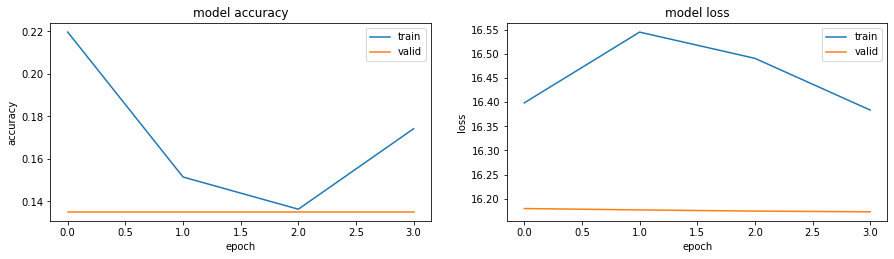


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.6637 - accuracy: 0.1351

LOSS:	15.663698196411133 	 ACCURACY:	0.13513512909412384
[15.663698196411133, 0.13513512909412384]



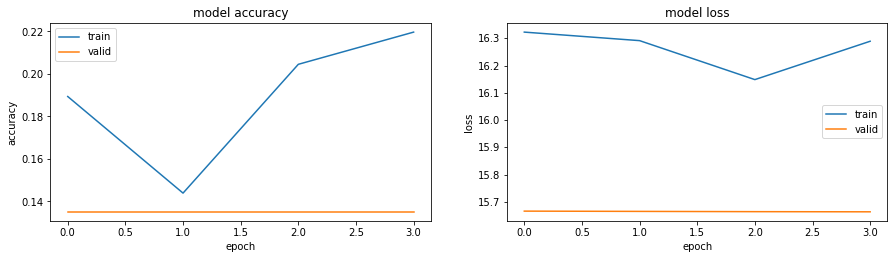


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.48649

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.48649

Epoch 10: val_accuracy did not improve from 0.48649
Epoch 10: early stopping
2/2 [===

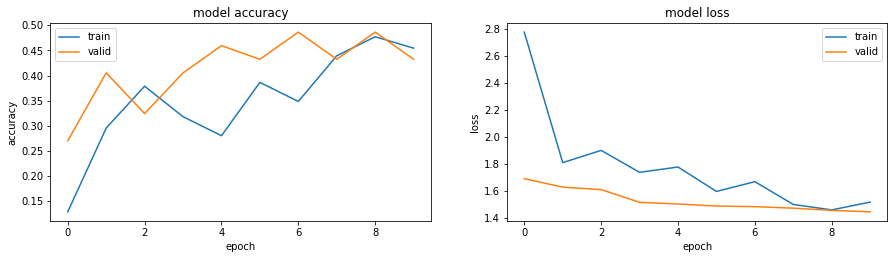


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.2508 - accuracy: 0.1892

LOSS:	2.2507894039154053 	 ACCURACY:	0.18918919563293457
[2.2507894039154053, 0.18918919563293457]



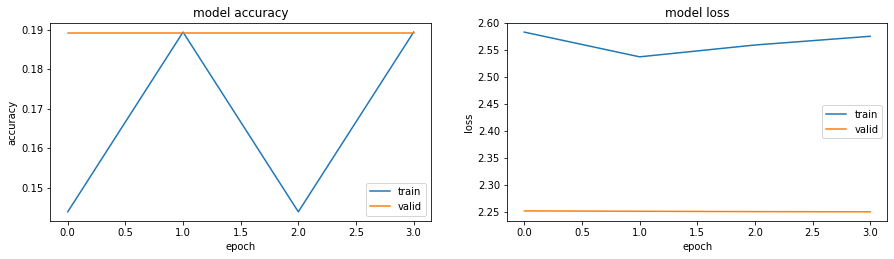


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 3.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 3.0729 - accuracy: 0.1351

LOSS:	3.0729026794433594 	 ACCURACY:	0.13513512909412384
[3.0729026794433594, 0.13513512909412384]



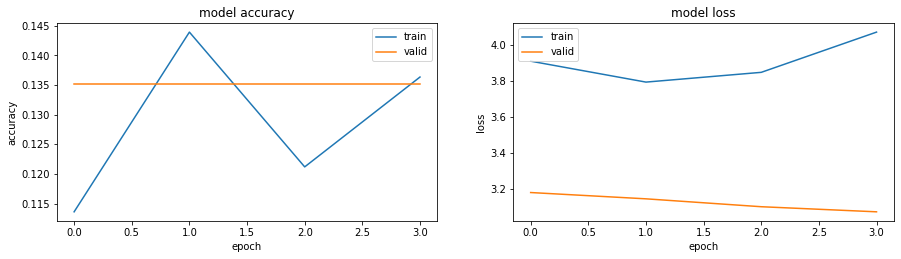


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.6383 - accuracy: 0.4054

LOSS:	15.638251304626465 	 ACCURACY:	0.4054054021835327
[15.638251304626465, 0.4054054021835327]



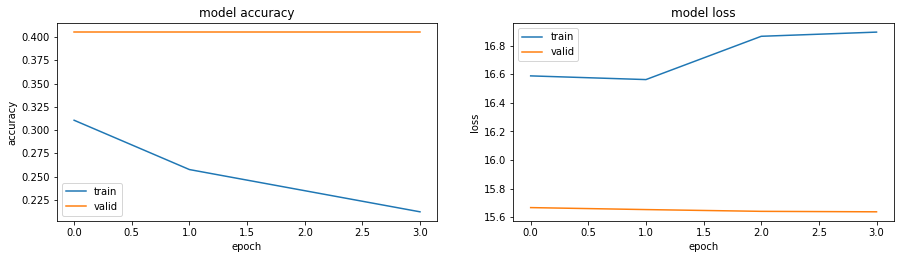


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: val_accuracy improved from 0.10811 to 0.27027, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.27027 to 0.40541, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: val_accuracy did not improve from 0.40541
Epoch 7: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.9183 - accuracy: 0.4054

LOSS:	2.9182755947113037 	 ACCURACY:	0.4054054021835327
[2.9182755947113037, 0.4054054021835327]



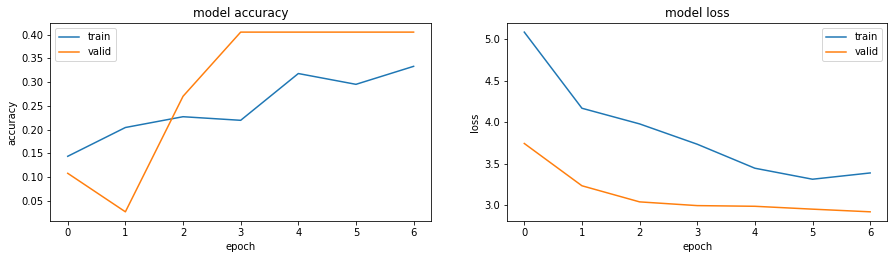


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 3.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 3.2585 - accuracy: 0.1351

LOSS:	3.2584869861602783 	 ACCURACY:	0.13513512909412384
[3.2584869861602783, 0.13513512909412384]



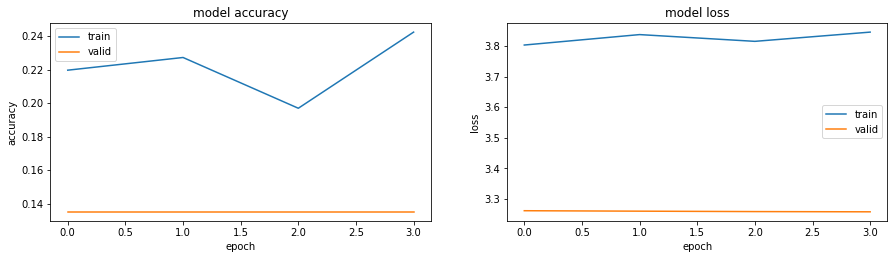


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.8737 - accuracy: 0.4054

LOSS:	2.873688220977783 	 ACCURACY:	0.4054054021835327
[2.873688220977783, 0.4054054021835327]



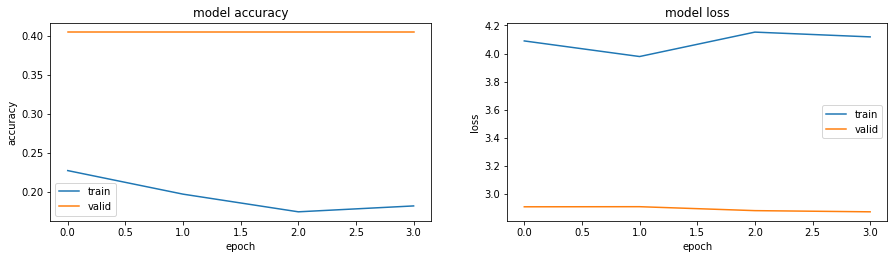


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 3.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.7129 - accuracy: 0.2432

LOSS:	15.712935447692871 	 ACCURACY:	0.2432432472705841
[15.712935447692871, 0.2432432472705841]



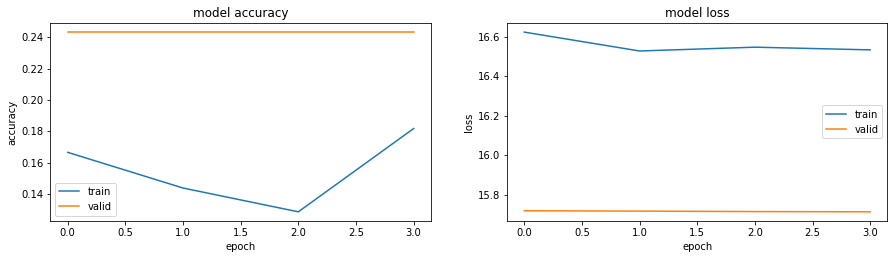


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.48649

Epoch 5: val_accuracy did not improve from 0.48649
Epoch 5: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 2.6117 - accuracy: 0.4595

LOSS:	2.6117141246795654 	 ACCURACY:	0.45945945382118225
[2.6117141246795654, 0.45945945382118225]



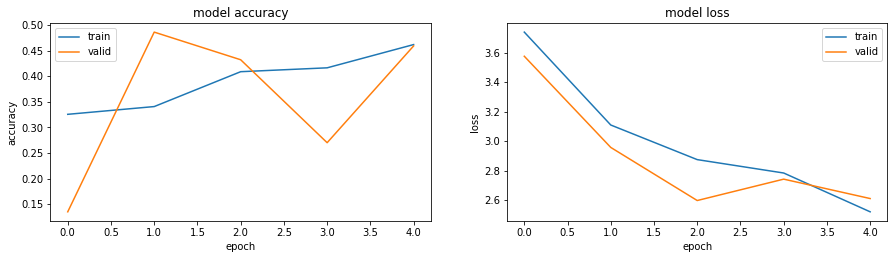


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 2.0e+00 5.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 1.6680 - accuracy: 0.4054

LOSS:	1.6679632663726807 	 ACCURACY:	0.4054054021835327
[1.6679632663726807, 0.4054054021835327]



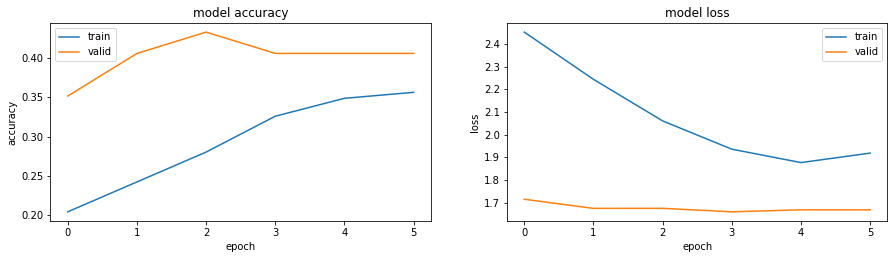


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 3.3083 - accuracy: 0.2432

LOSS:	3.308286428451538 	 ACCURACY:	0.2432432472705841
[3.308286428451538, 0.2432432472705841]



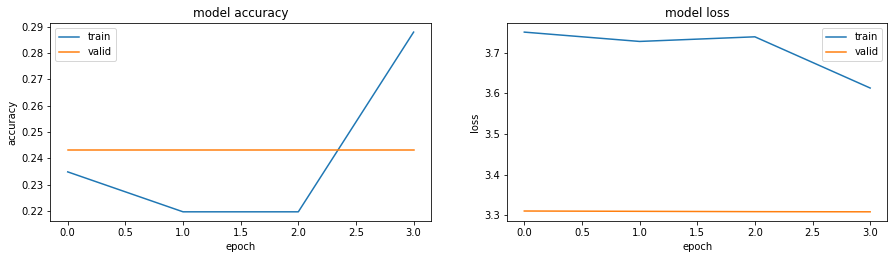


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: val_accuracy did not improve from 0.45946
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.7092 - accuracy: 0.4595

LOSS:	1.7091648578643799 	 ACCURACY:	0.45945945382118225
[1.7091648578643799, 0.45945945382118225]



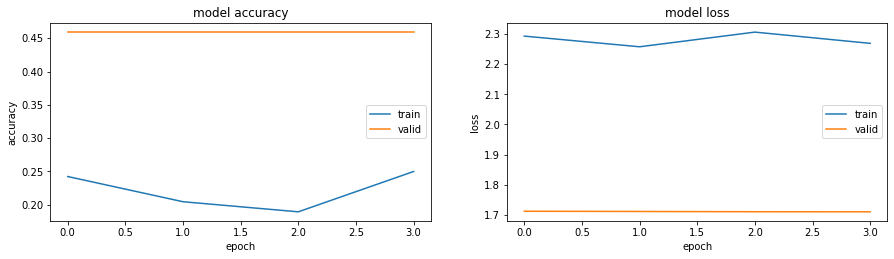


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.8712 - accuracy: 0.4054

LOSS:	1.8712191581726074 	 ACCURACY:	0.4054054021835327
[1.8712191581726074, 0.4054054021835327]



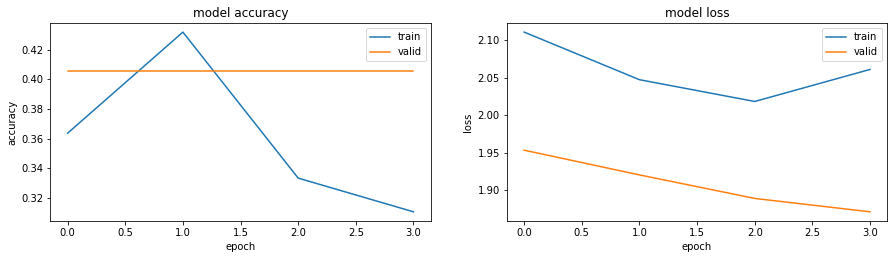


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 1.0e+00 5.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 16.1325 - accuracy: 0.1081

LOSS:	16.13254165649414 	 ACCURACY:	0.10810811072587967
[16.13254165649414, 0.10810811072587967]



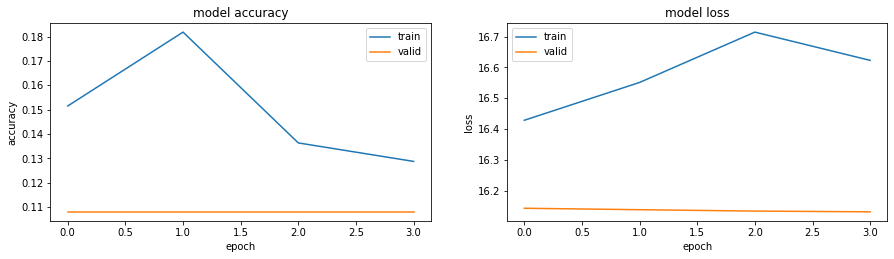


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 2.9890 - accuracy: 0.1892

LOSS:	2.9890127182006836 	 ACCURACY:	0.18918919563293457
[2.9890127182006836, 0.18918919563293457]



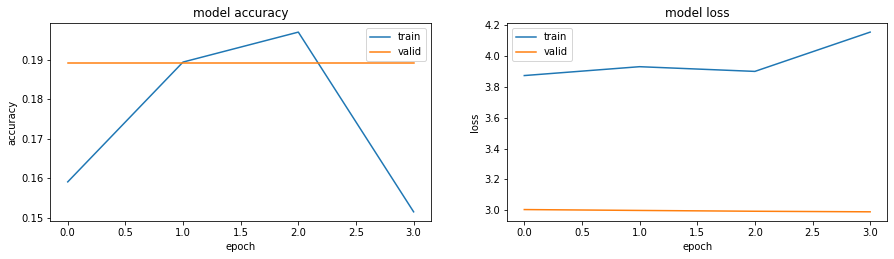


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 2.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 3.1674 - accuracy: 0.1351

LOSS:	3.1673760414123535 	 ACCURACY:	0.13513512909412384
[3.1673760414123535, 0.13513512909412384]



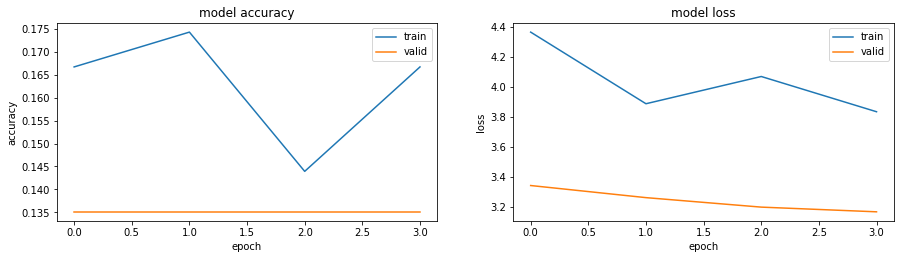


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.18919 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.24324

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.24324

Epoch 6: val_accuracy did not improve from 0.24324
Epoch 6: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 15.3057 - accuracy: 0.2432

LOSS:	15.305747985839844 	 ACCURACY:	0.2432432472705841
[15.305747985839844, 0.2432432472705841]



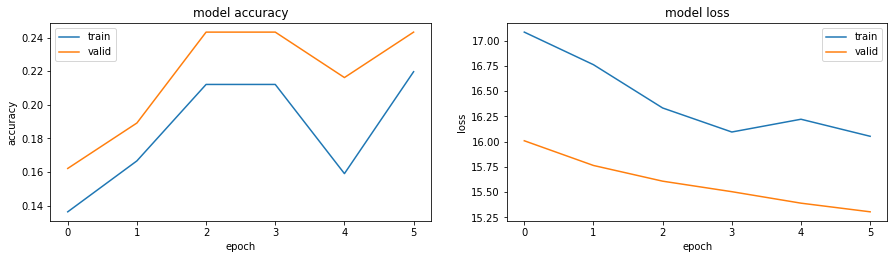


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 4.7801 - accuracy: 0.1351

LOSS:	4.780068874359131 	 ACCURACY:	0.13513512909412384
[4.780068874359131, 0.13513512909412384]



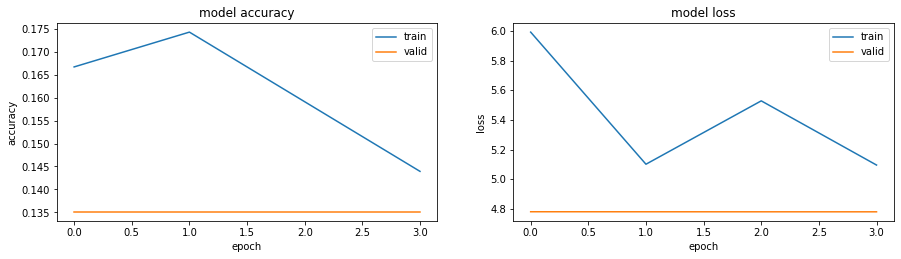


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.8207 - accuracy: 0.4054

LOSS:	2.820749044418335 	 ACCURACY:	0.4054054021835327
[2.820749044418335, 0.4054054021835327]



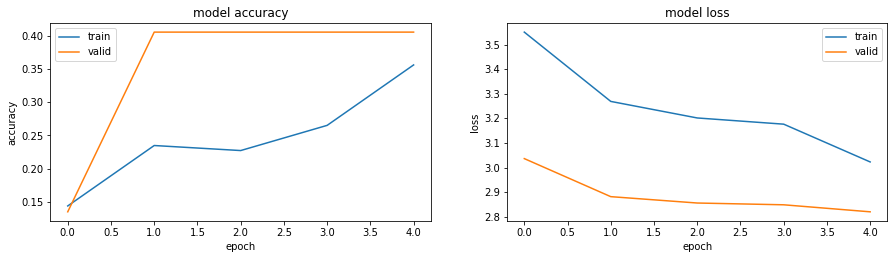


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 7.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.29730 to 0.35135, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: val_accuracy did not improve from 0.40541
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.8894 - accuracy: 0.4054

LOSS:	2.8893589973449707 	 ACCURACY:	0.4054054021835327
[2.8893589973449707, 0.405

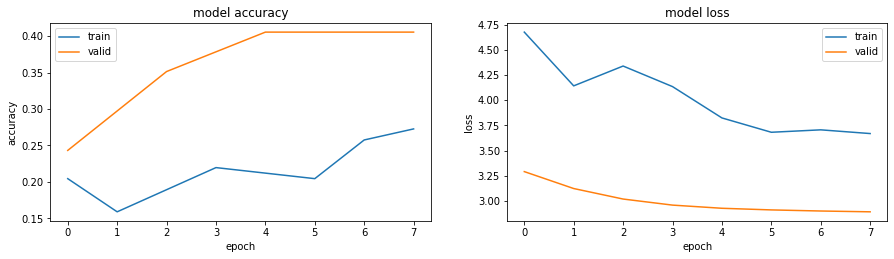


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.32432

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.32432

Epoch 6: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.35135

Epoch 8: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.37838

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy did not improve from 0.37838



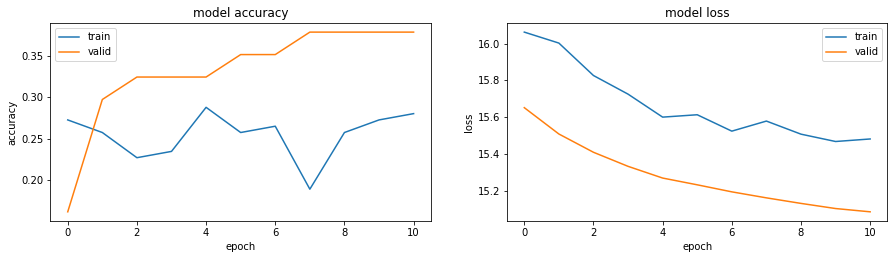


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.48649

Epoch 5: val_accuracy did not improve from 0.48649
Epoch 5: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 1.4633 - accuracy: 0.4595

LOSS:	1.4632751941680908 	 ACCURACY:	0.45945945382118225
[1.4632751941680908, 0.45945945382118225]



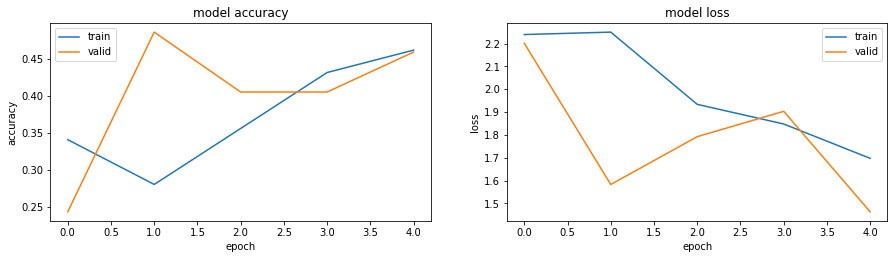


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 16.5250 - accuracy: 0.1892

LOSS:	16.52495765686035 	 ACCURACY:	0.18918919563293457
[16.52495765686035, 0.18918919563293457]



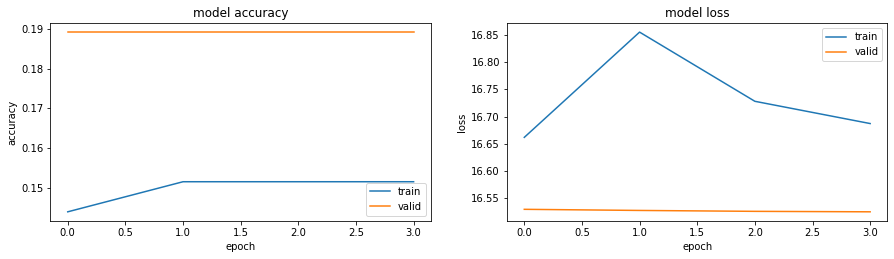


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 2.0e+00 7.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.0373 - accuracy: 0.1892

LOSS:	2.0373451709747314 	 ACCURACY:	0.18918919563293457
[2.0373451709747314, 0.18918919563293457]



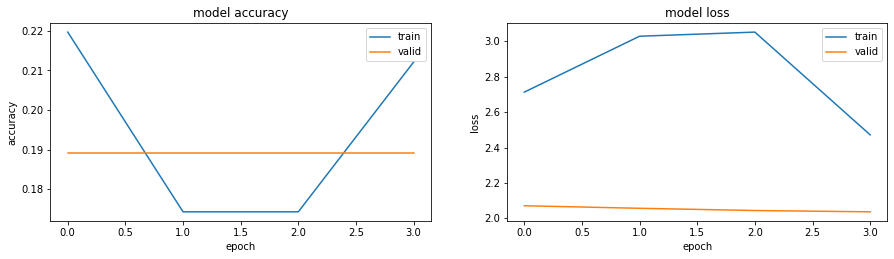


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 1.0e+00 3.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.29730

Epoch 5: val_accuracy did not improve from 0.29730
Epoch 5: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.4646 - accuracy: 0.2973

LOSS:	15.46460247039795 	 ACCURACY:	0.29729729890823364
[15.46460247039795, 0.29729729890823364]



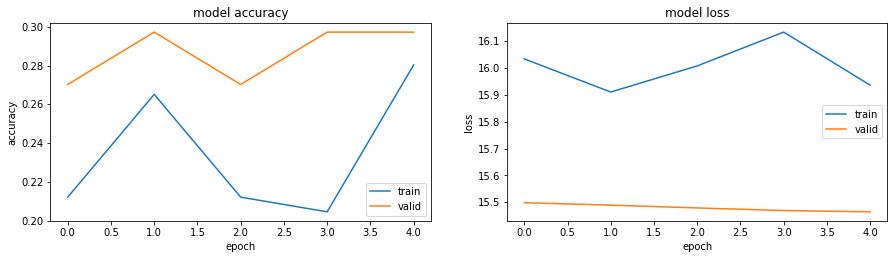


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 15.8742 - accuracy: 0.1622

LOSS:	15.874227523803711 	 ACCURACY:	0.1621621549129486
[15.874227523803711, 0.1621621549129486]



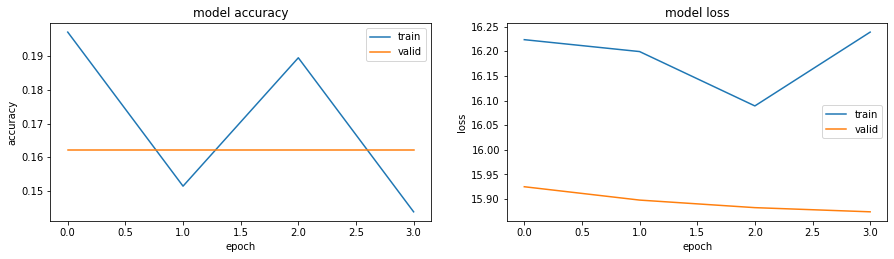


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 2.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: val_accuracy did not improve from 0.48649
Epoch 7: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 14.2742 - accuracy: 0.4865

LOSS:	14.274199485778809 	 ACCURACY:	0.4864864945411682
[14.274199485778809, 0.4864864945411682]



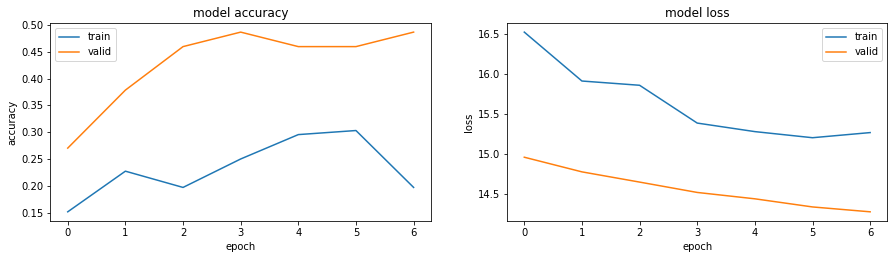


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.7720 - accuracy: 0.2162

LOSS:	1.7719932794570923 	 ACCURACY:	0.21621622145175934
[1.7719932794570923, 0.21621622145175934]



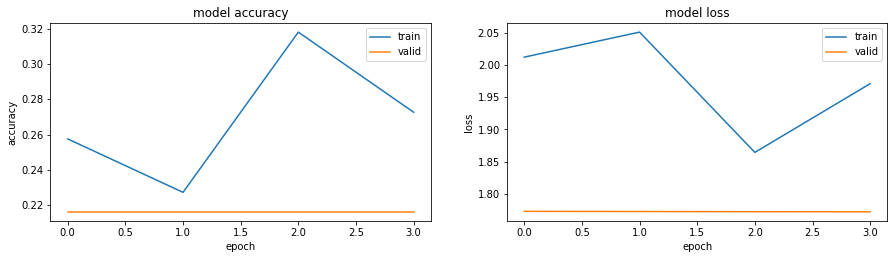


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 2.0e+00 5.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: val_accuracy did not improve from 0.48649
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 1.5005 - accuracy: 0.4595

LOSS:	1.5005344152450562 	 ACCURACY:	0.45945945382118225
[1.5005344152450562, 0.45945945382118225]



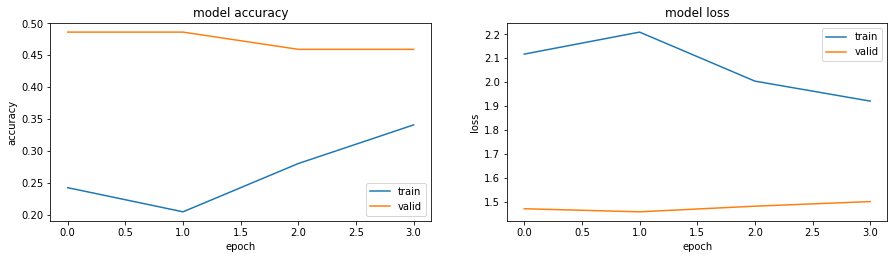


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 16.3503 - accuracy: 0.2432

LOSS:	16.35028076171875 	 ACCURACY:	0.2432432472705841
[16.35028076171875, 0.2432432472705841]



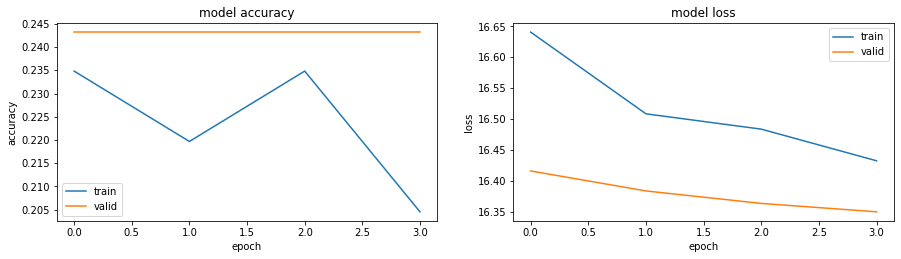


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.29730 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.37838

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.37838

Epoch 7: val_accuracy did not improve from 0.37838
Epoch 7: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.9708 - accuracy: 0.3243

LOSS:	2.9708304405212402 	 ACCURACY:	0.3243243098258972
[2.9708304405212402, 0.3243243098258972]



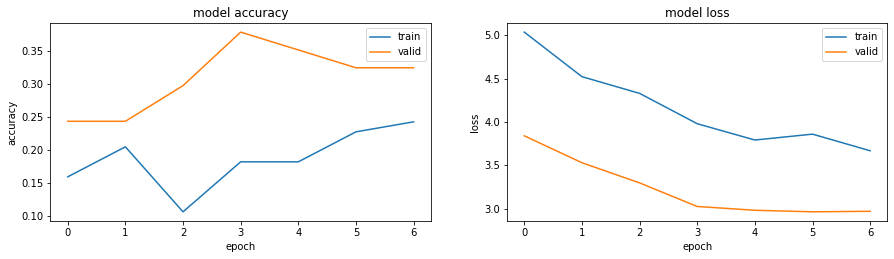


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 3.4417 - accuracy: 0.2432

LOSS:	3.441681146621704 	 ACCURACY:	0.2432432472705841
[3.441681146621704, 0.2432432472705841]



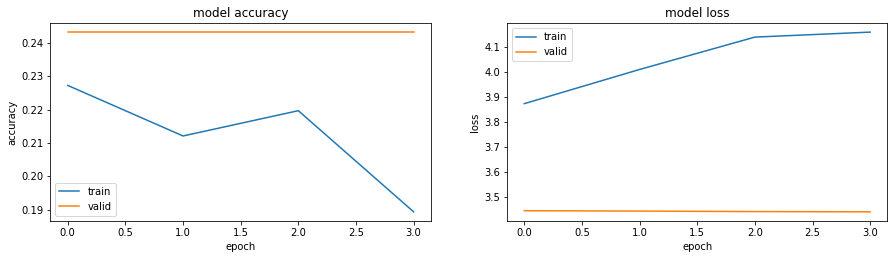


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.3861 - accuracy: 0.5135

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.45946 to 0.54054, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.54054

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: val_accuracy improved from 0.54054 to 0.56757, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: val_accuracy did not improve from 0.56757
Epoch 9: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.52

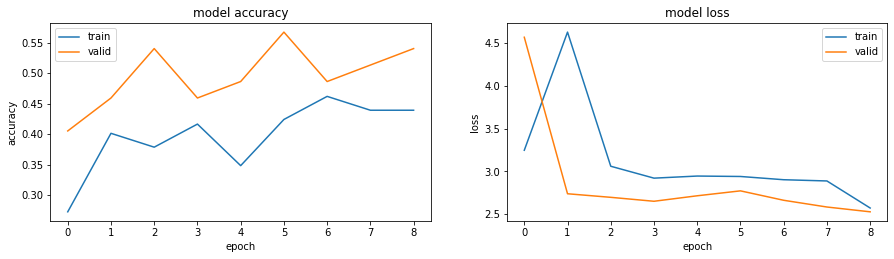


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 2.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.2079 - accuracy: 0.1622

LOSS:	2.2079288959503174 	 ACCURACY:	0.1621621549129486
[2.2079288959503174, 0.1621621549129486]



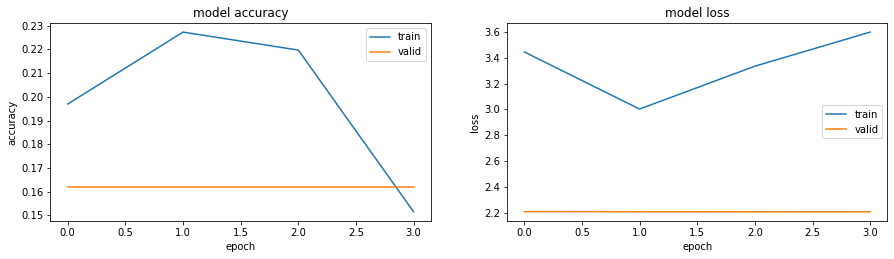


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.40541

Epoch 9: val_accuracy did not improve from 0.40541
Epoch 9: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 2.9283 - accuracy: 0.4054

LOSS:	2.928305149078369 	 ACCURACY:	0.405405402183532

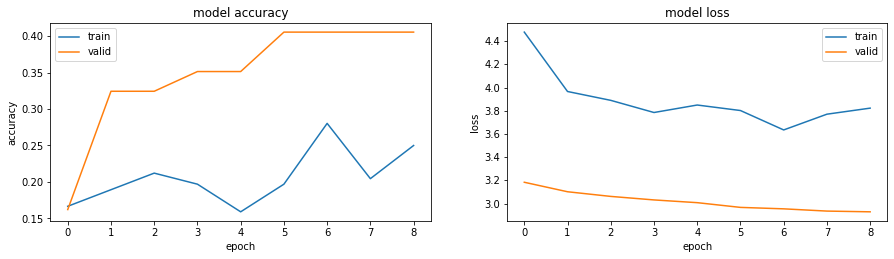


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy did not improve from 0.43243
Epoch 5: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 2.2447 - accuracy: 0.4054

LOSS:	2.244662046432495 	 ACCURACY:	0.4054054021835327
[2.244662046432495, 0.4054054021835327]



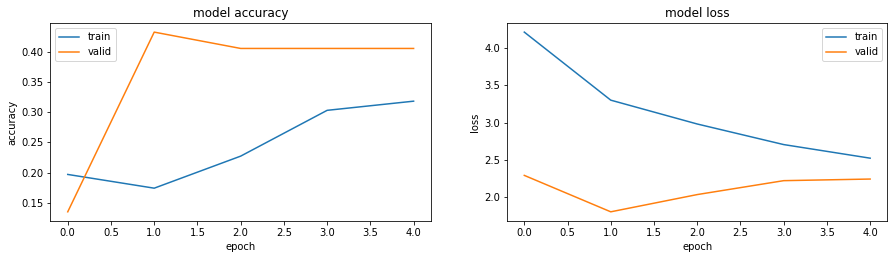


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 15.2508 - accuracy: 0.4324

LOSS:	15.250772476196289 	 ACCURACY:	0.4324324429035187
[15.250772476196289, 0.4324324429035187]



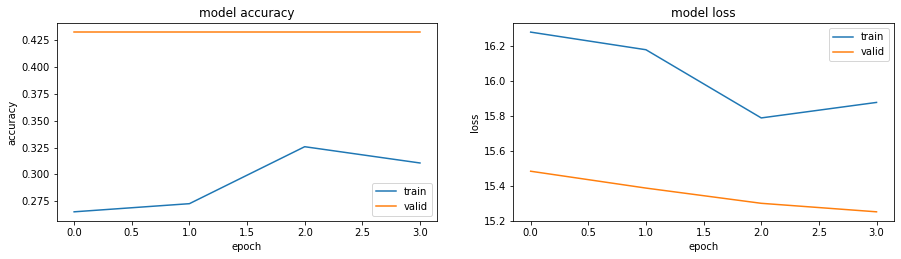


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 3.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: val_accuracy did not improve from 0.45946
Epoch 5: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.8178 - accuracy: 0.4595

LOSS:	2.81776762008667 	 ACCURACY:	0.45945945382118225
[2.81776762008667, 0.45945945382118225]



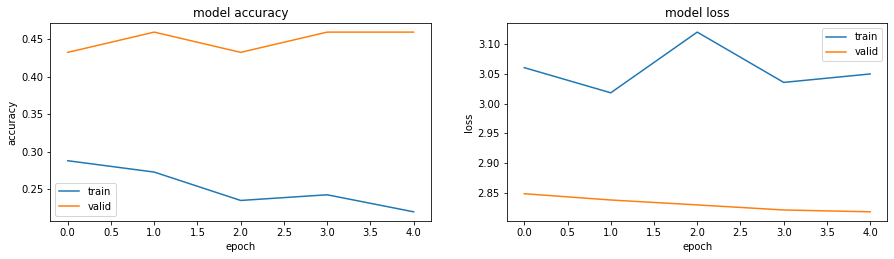


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 16.2731 - accuracy: 0.1351

LOSS:	16.273115158081055 	 ACCURACY:	0.13513512909412384
[16.273115158081055, 0.13513512909412384]



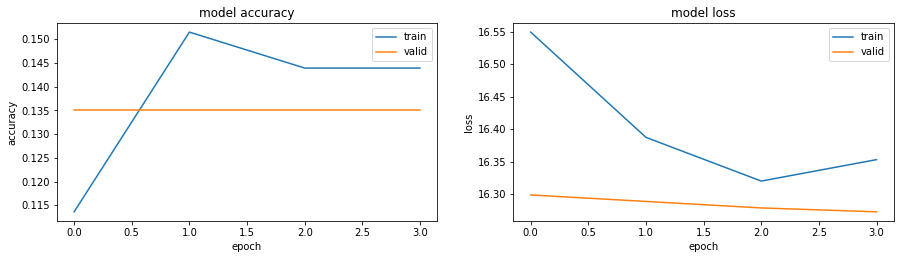


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.1081 - accuracy: 0.1081

LOSS:	2.1080973148345947 	 ACCURACY:	0.10810811072587967
[2.1080973148345947, 0.10810811072587967]



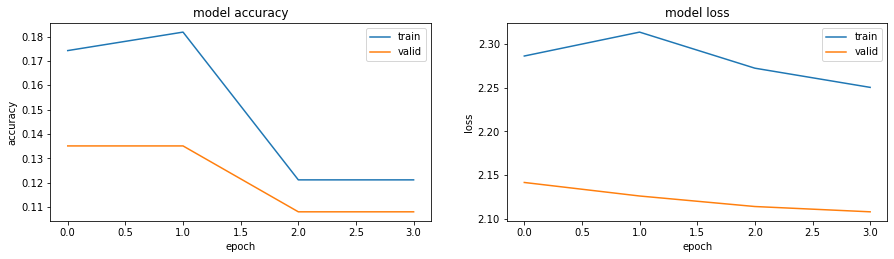


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.32432

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy did not improve from 0.32432
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.9927 - accuracy: 0.3243

LOSS:	2.9927005767822266 	 ACCURACY:	0.3243243098258972
[2.9927005767822266, 0.3243243098258972]



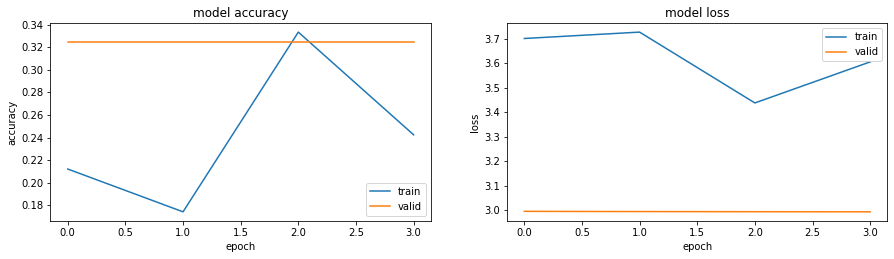


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.0385 - accuracy: 0.1351

LOSS:	2.038489580154419 	 ACCURACY:	0.13513512909412384
[2.038489580154419, 0.13513512909412384]



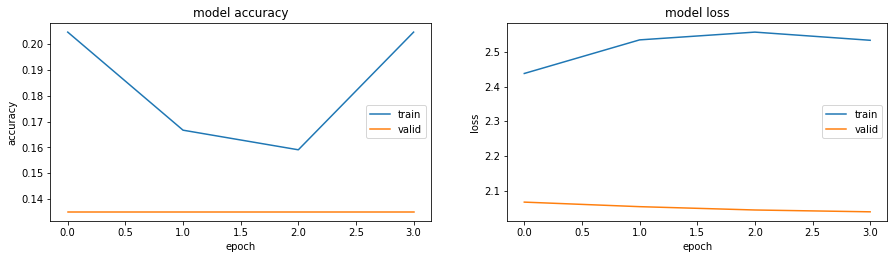


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 16.5669 - accuracy: 0.1351

LOSS:	16.566911697387695 	 ACCURACY:	0.13513512909412384
[16.566911697387695, 0.13513512909412384]



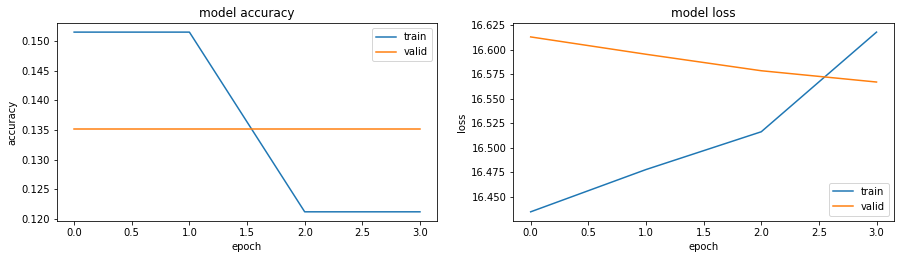


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 1.6018 - accuracy: 0.4324

LOSS:	1.6017948389053345 	 ACCURACY:	0.4324324429035187
[1.6017948389053345, 0.4324324429035187]



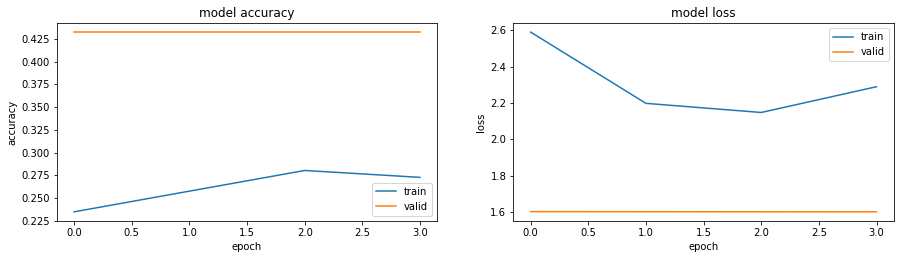


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.24324, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.24324

Epoch 5: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.32432

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.32432

Epoch 10: val_accuracy did not improve from 0.32432
Epo

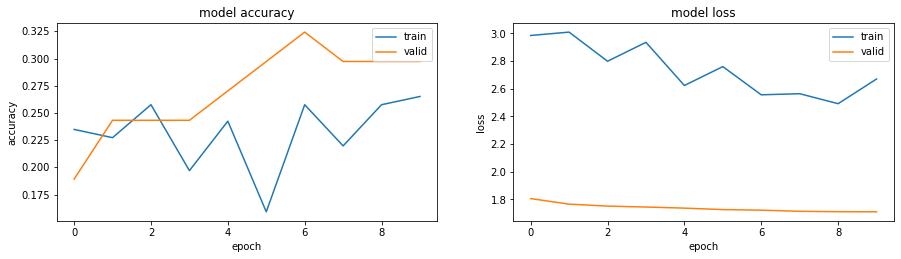


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 2.0378 - accuracy: 0.2432

LOSS:	2.0377678871154785 	 ACCURACY:	0.2432432472705841
[2.0377678871154785, 0.2432432472705841]



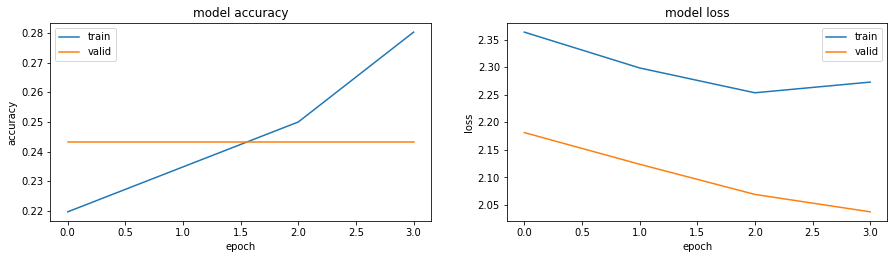


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 1.0e+00 5.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.5466 - accuracy: 0.4324

LOSS:	1.5465776920318604 	 ACCURACY:	0.4324324429035187
[1.5465776920318604, 0.4324324429035187]



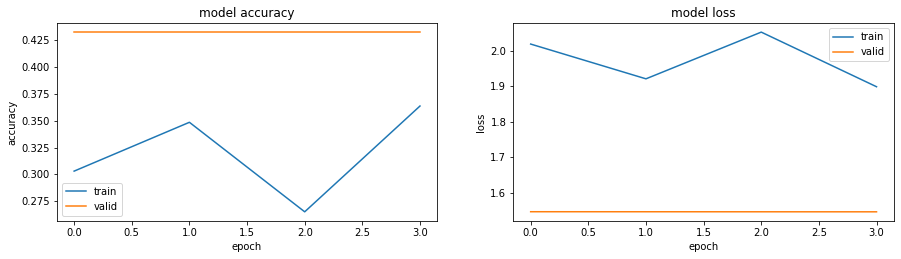


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 2.0e+00 3.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.2419 - accuracy: 0.1351

LOSS:	2.241933584213257 	 ACCURACY:	0.13513512909412384
[2.241933584213257, 0.13513512909412384]



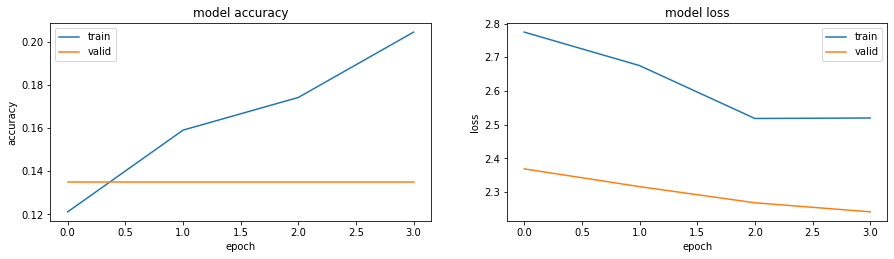


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-01 2.0e+00 5.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 16.9424 - accuracy: 0.1622

LOSS:	16.942413330078125 	 ACCURACY:	0.1621621549129486
[16.942413330078125, 0.1621621549129486]



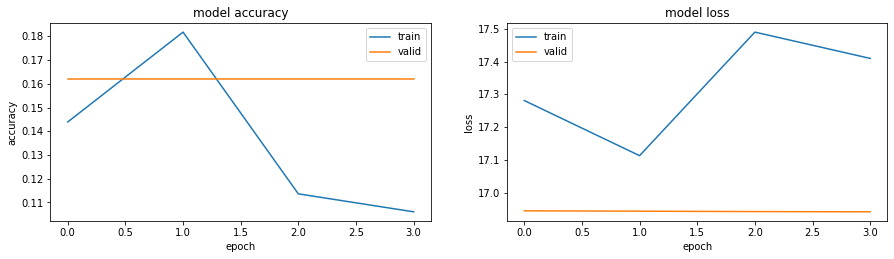


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 5.0e-01 3.2e+01 1.0e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 4.5504 - accuracy: 0.0811

LOSS:	4.5504350662231445 	 ACCURACY:	0.0810810774564743
[4.5504350662231445, 0.0810810774564743]



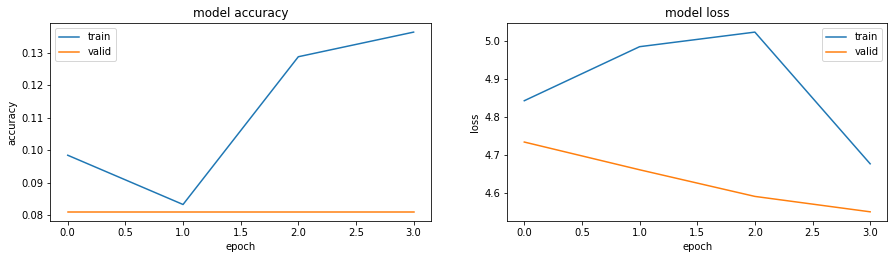


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 3.4595 - accuracy: 0.2432

LOSS:	3.4594931602478027 	 ACCURACY:	0.2432432472705841
[3.4594931602478027, 0.2432432472705841]



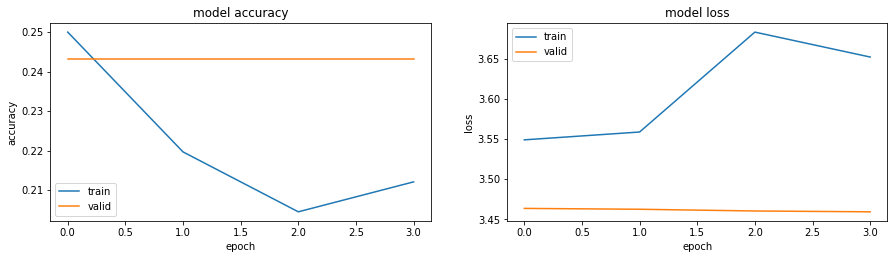


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 15.4348 - accuracy: 0.2162

LOSS:	15.43480110168457 	 ACCURACY:	0.21621622145175934
[15.43480110168457, 0.21621622145175934]



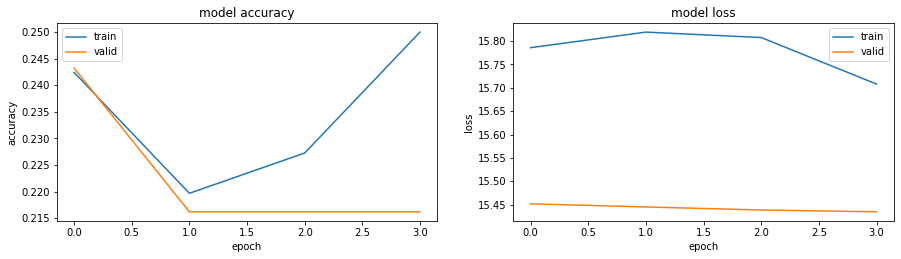


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 16.2973 - accuracy: 0.1081

LOSS:	16.297279357910156 	 ACCURACY:	0.10810811072587967
[16.297279357910156, 0.10810811072587967]



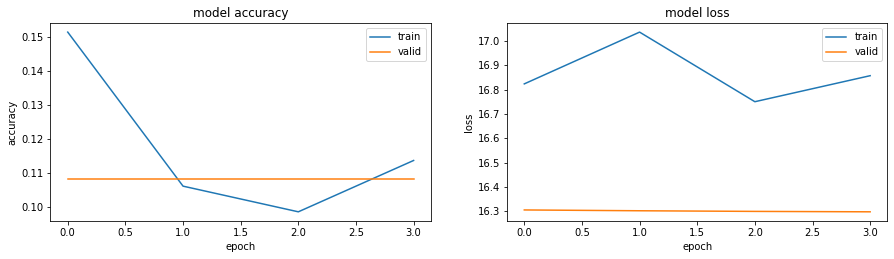


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 1.7099 - accuracy: 0.3784

LOSS:	1.7099162340164185 	 ACCURACY:	0.37837839126586914
[1.7099162340164185, 0.37837839126586914]



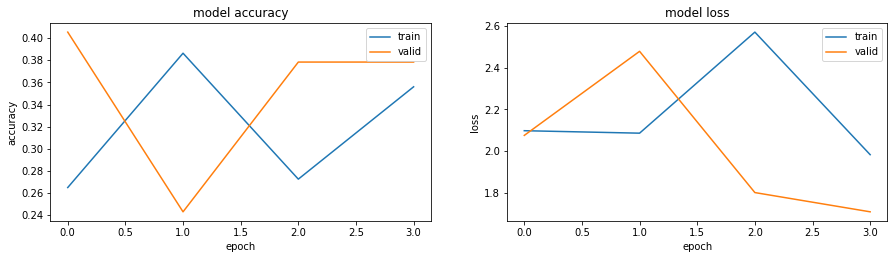


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 2.0e+00 3.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 15.4989 - accuracy: 0.4054

LOSS:	15.49885368347168 	 ACCURACY:	0.4054054021835327
[15.49885368347168, 0.4054054021835327]



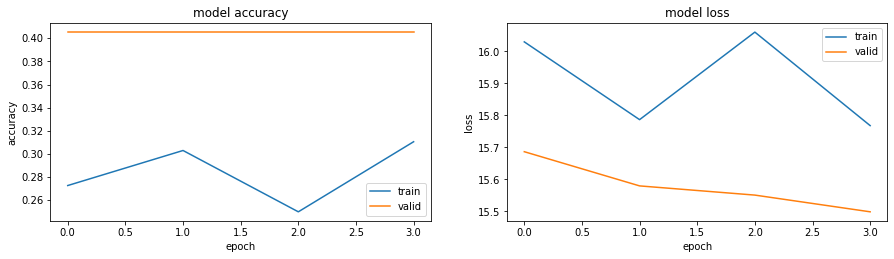


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy did not improve from 0.43243
Epoch 5: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 12.6412 - accuracy: 0.4324

LOSS:	12.641170501708984 	 ACCURACY:	0.4324324429035187
[12.641170501708984, 0.4324324429035187]



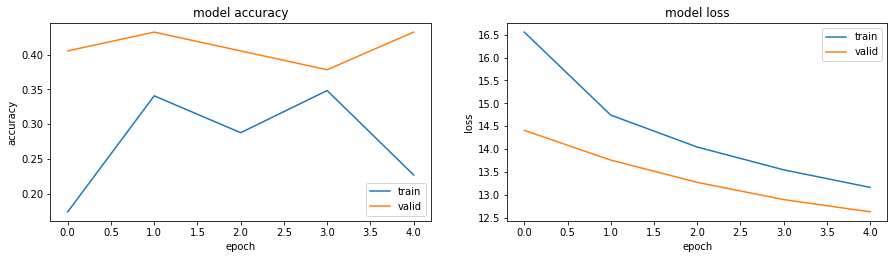


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 1.8859 - accuracy: 0.2432

LOSS:	1.8859117031097412 	 ACCURACY:	0.2432432472705841
[1.8859117031097412, 0.2432432472705841]



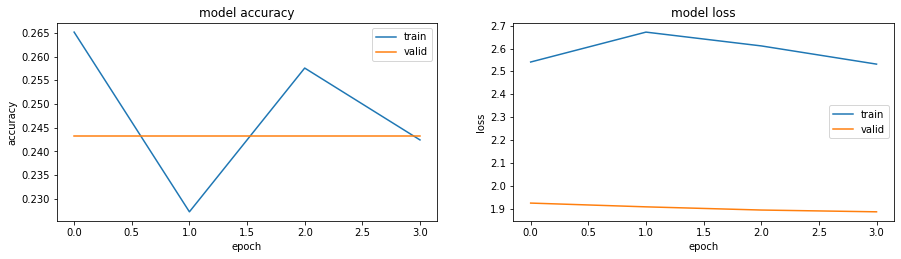


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 3.0912 - accuracy: 0.1892

LOSS:	3.0912129878997803 	 ACCURACY:	0.18918919563293457
[3.0912129878997803, 0.18918919563293457]



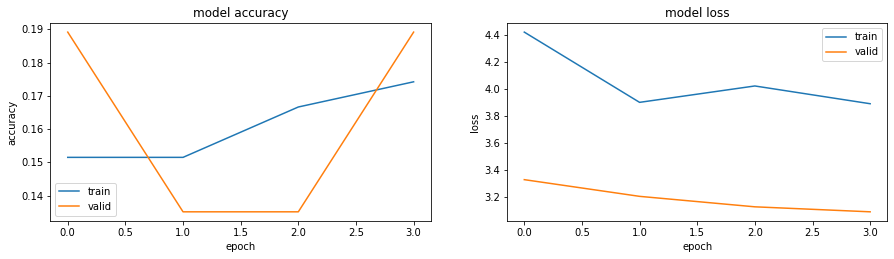


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 3.0e+00 5.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.05405

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.05405

Epoch 4: val_accuracy did not improve from 0.05405
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 3.9999 - accuracy: 0.0541

LOSS:	3.999936103820801 	 ACCURACY:	0.054054055362939835
[3.999936103820801, 0.054054055362939835]



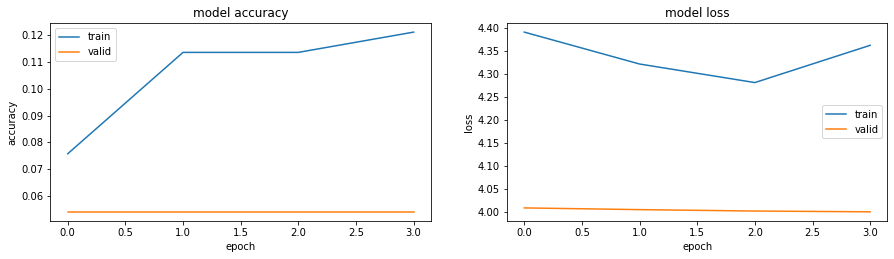


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 3.0e+00 7.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 1.9821 - accuracy: 0.1081

LOSS:	1.9820841550827026 	 ACCURACY:	0.10810811072587967
[1.9820841550827026, 0.10810811072587967]



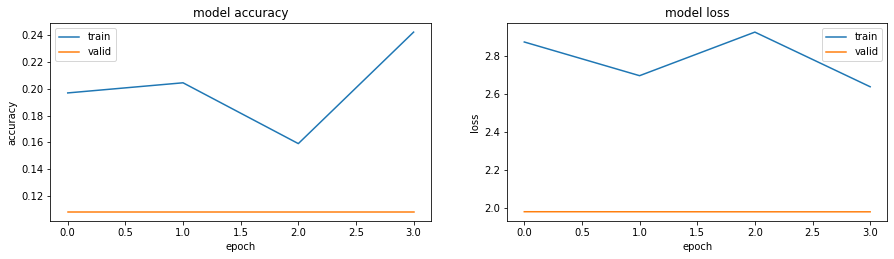


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.5478 - accuracy: 0.4054

LOSS:	1.5478272438049316 	 ACCURACY:	0.4054054021835327
[1.5478272438049316, 0.4054054021835327]



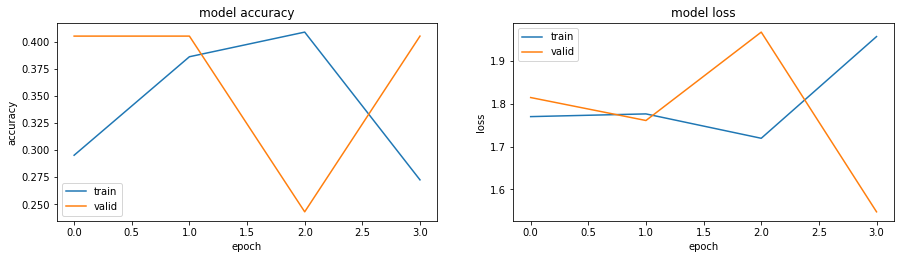


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.56757, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.56757

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.56757

Epoch 5: val_accuracy did not improve from 0.56757
Epoch 5: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.5273 - accuracy: 0.4324

LOSS:	1.527315616607666 	 ACCURACY:	0.4324324429035187
[1.527315616607666, 0.4324324429035187]



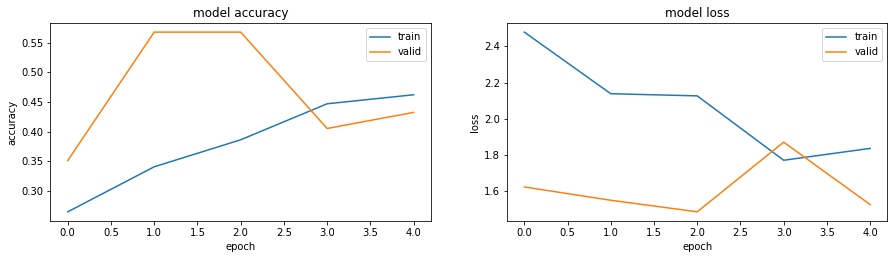


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 15.9530 - accuracy: 0.0811

LOSS:	15.953039169311523 	 ACCURACY:	0.0810810774564743
[15.953039169311523, 0.0810810774564743]



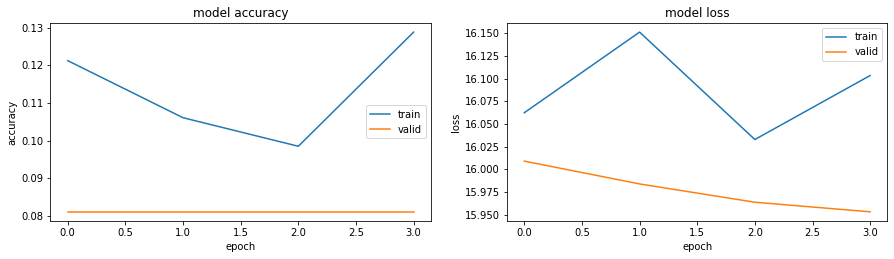


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 5.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 3.6919 - accuracy: 0.1351

LOSS:	3.6919472217559814 	 ACCURACY:	0.13513512909412384
[3.6919472217559814, 0.13513512909412384]



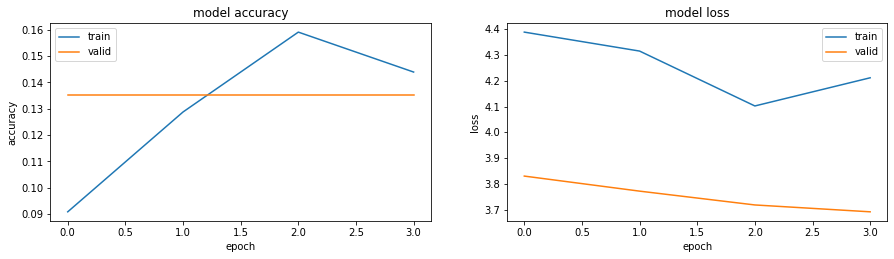


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.9964 - accuracy: 0.1081

LOSS:	1.99644136428833 	 ACCURACY:	0.10810811072587967
[1.99644136428833, 0.10810811072587967]



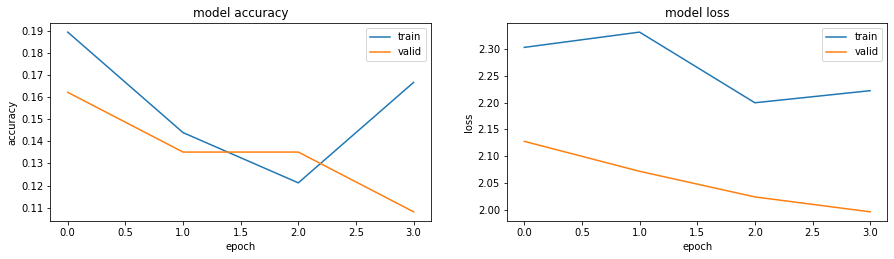


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 15.7805 - accuracy: 0.1081

LOSS:	15.780515670776367 	 ACCURACY:	0.10810811072587967
[15.780515670776367, 0.10810811072587967]



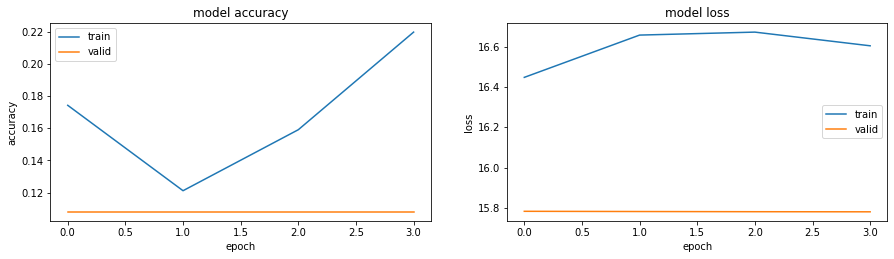


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: val_accuracy improved from 0.24324 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.40541

Epoch 6: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.43243

Epoch 8: val_accuracy improved from 0.43243 to 0.51351, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.51351

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.51351

Epoch 11: val_accuracy did not i

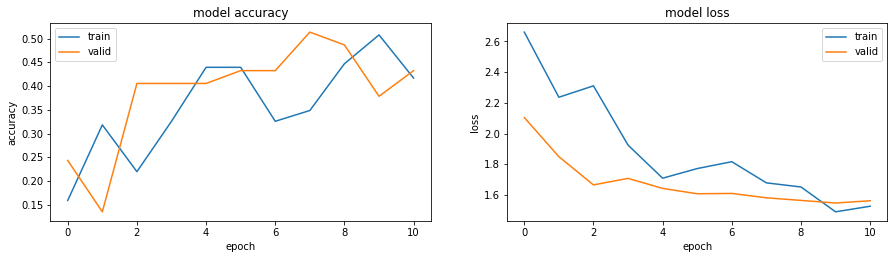


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 2.0e+00 7.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 1.9105 - accuracy: 0.1081

LOSS:	1.9104574918746948 	 ACCURACY:	0.10810811072587967
[1.9104574918746948, 0.10810811072587967]



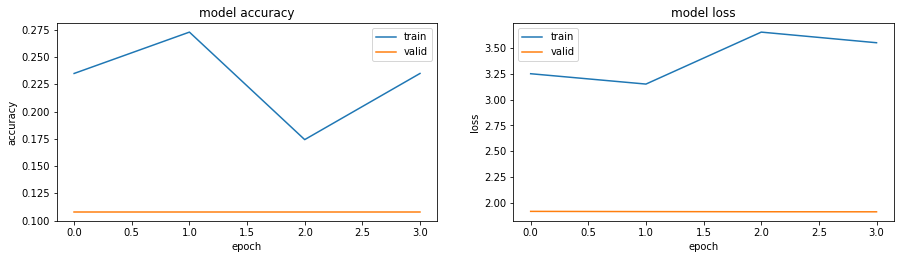


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 2.0e+00 3.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.08108 to 0.10811, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.10811 to 0.32432, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: val_accuracy did not improve from 0.40541
Epoch 8: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 2.9290 - accuracy: 0.4054

LOSS:	2.92903733253479 	 ACCURACY:	0.4054054021835327
[2.92903733253479, 0.40540

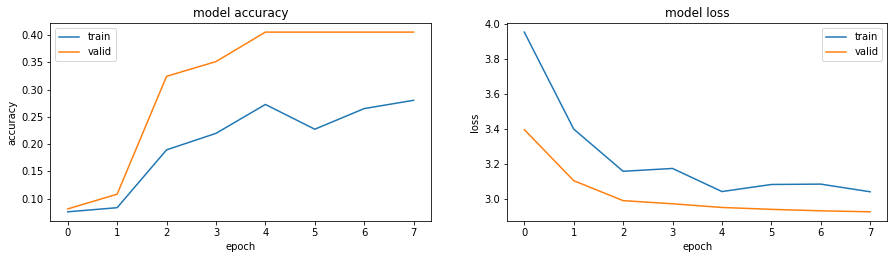


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 16.3103 - accuracy: 0.1351

LOSS:	16.310253143310547 	 ACCURACY:	0.13513512909412384
[16.310253143310547, 0.13513512909412384]



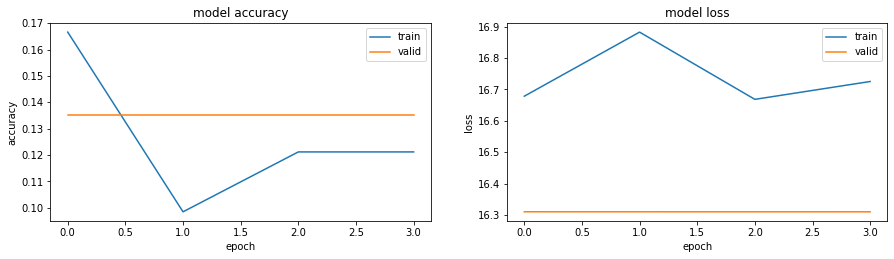


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: val_accuracy improved from 0.13514 to 0.16216, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.18919

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.18919

Epoch 7: val_accuracy did not improve from 0.18919
Epoch 7: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 15.4090 - accuracy: 0.1892

LOSS:	15.40904426574707 	 ACCURACY:	0.18918919563293457
[15.40904426574707, 0.18918919563293457]



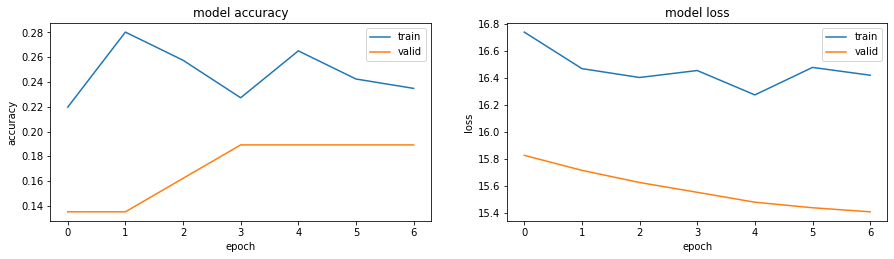


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.29730, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.29730

Epoch 5: val_accuracy did not improve from 0.29730
Epoch 5: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 15.4625 - accuracy: 0.2162

LOSS:	15.462454795837402 	 ACCURACY:	0.21621622145175934
[15.462454795837402, 0.21621622145175934]



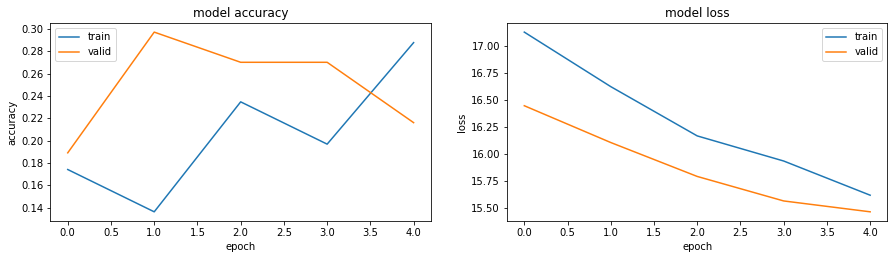


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 4ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.9017 - accuracy: 0.2432

LOSS:	2.9016597270965576 	 ACCURACY:	0.2432432472705841
[2.9016597270965576, 0.2432432472705841]



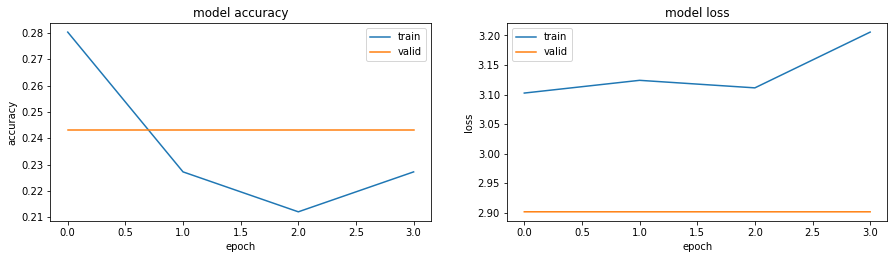


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 3.0e+00 3.0e-01 3.2e+01 2.0e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: val_accuracy improved from 0.13514 to 0.18919, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.18919 to 0.27027, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.27027 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.43243

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.43243

Epoch 10: val_accuracy did not improve from 0.43243
Epoch 10: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 1.5

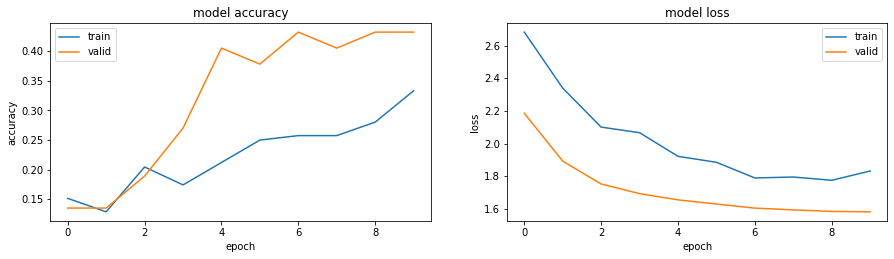


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 1.0e+00 3.0e-01 3.2e+01 3.0e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2.7293 - accuracy: 0.2703

LOSS:	2.7293338775634766 	 ACCURACY:	0.2702702581882477
[2.7293338775634766, 0.2702702581882477]



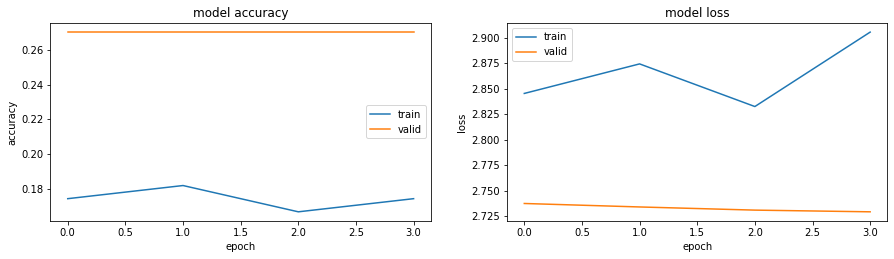


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 2.5270 - accuracy: 0.5405

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.48649

Epoch 8: val_accuracy did not improve from 0.48649
Epoch 8: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 2.5672 - accuracy: 0.4865

LOSS:	2.567225217819214 	 ACCURACY:	0.4864864945411682
[2.567225217819214, 0.4864864945411682]



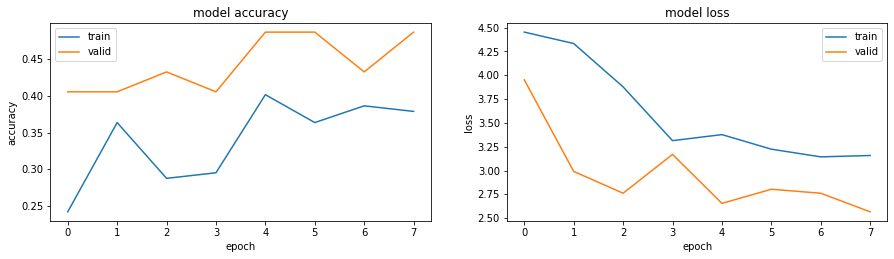

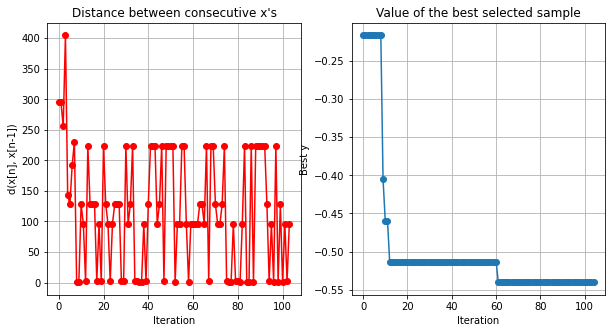

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0],
  evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	64.0
	learning_rate:	0.001
	l2:	0.01
	activation:	tanh
	rate:	0.5
	batch:	128.0
 optim RMSprop
optimized accuracy: [0.54054052]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 6ms/step - loss: 2.5270 - accuracy: 0.5405
Restored model, accuracy: 54.05%


In [ ]:
best_model.evaluate(features_valid, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 2.5270 - accuracy: 0.5405


[2.5270392894744873, 0.5405405163764954]

In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Sat May 28 14:00:19 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           222.47994565963745 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [ ]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1/1 [==============================] - 0s 21ms/step - loss: 2.8060 - accuracy: 0.3750
Restored model, accuracy: 37.50%


In [ ]:
best_model.evaluate(features_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 2.8060 - accuracy: 0.3750


[2.805981397628784, 0.375]